# Principal Component Analysis (PCA) with EEG waveforms

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["legend.fontsize"] = 14

### Learning Objectives

1. You will be able to apply PCA to time series.
2. You will be able to classify time series and visualize the classification in a low number of PCs.
3. You will be able to visualize classified time series in higher than three dimensions.
4. You will appreciate how classification of time series waveforms could be beneficial for interpreting experimental data.

### EEG recordings

In [2]:
EEGs = np.load("EEGs.npy")

# [channel, time, trial]
EEGs.shape

(64, 640, 99)

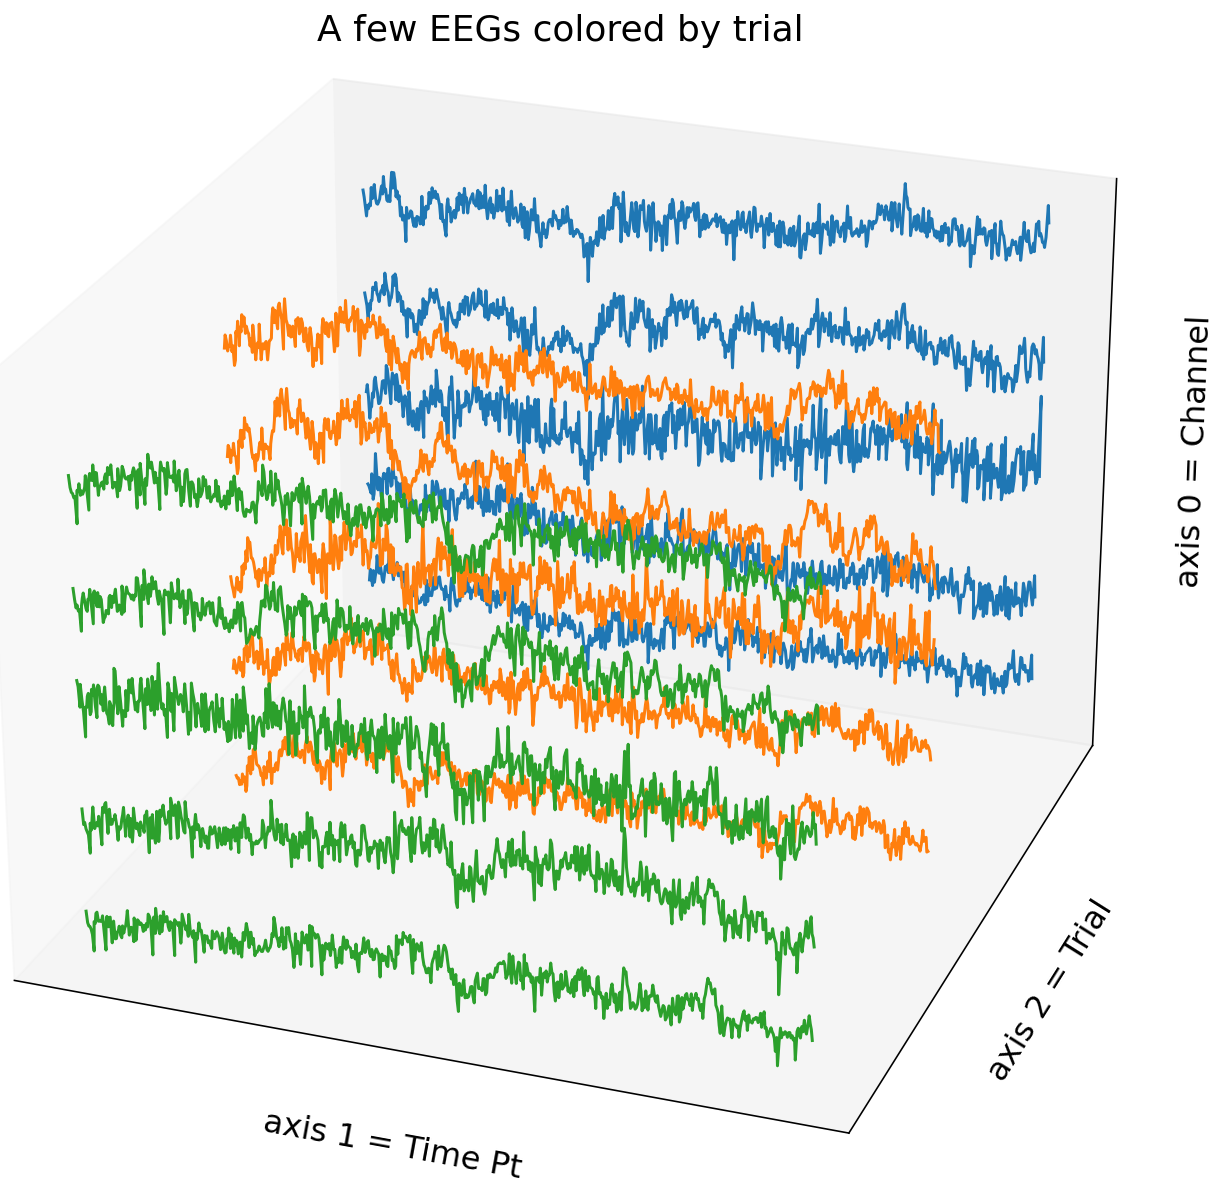

In [3]:
# Visualize EEGs from a few channels and trials
cmap = plt.cm.get_cmap('tab10', 10).colors
figsize3d = (8,8)
dist3d = 8
fig = plt.figure(figsize=figsize3d)
ax = plt.axes(projection='3d')
for channel in range(5):
    for trial in range(3):
        ax.plot(np.arange(640), np.ones(640) * trial, EEGs[channel,:,trial] - 50*channel, color=cmap[trial%10,:])
ax.set_xlabel('axis 1 = Time Pt')
ax.set_ylabel('axis 2 = Trial')
ax.set_zlabel('axis 0 = Channel')
ax.set_title('A few EEGs colored by trial')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(-155, -110)
ax.dist = dist3d
plt.tight_layout();

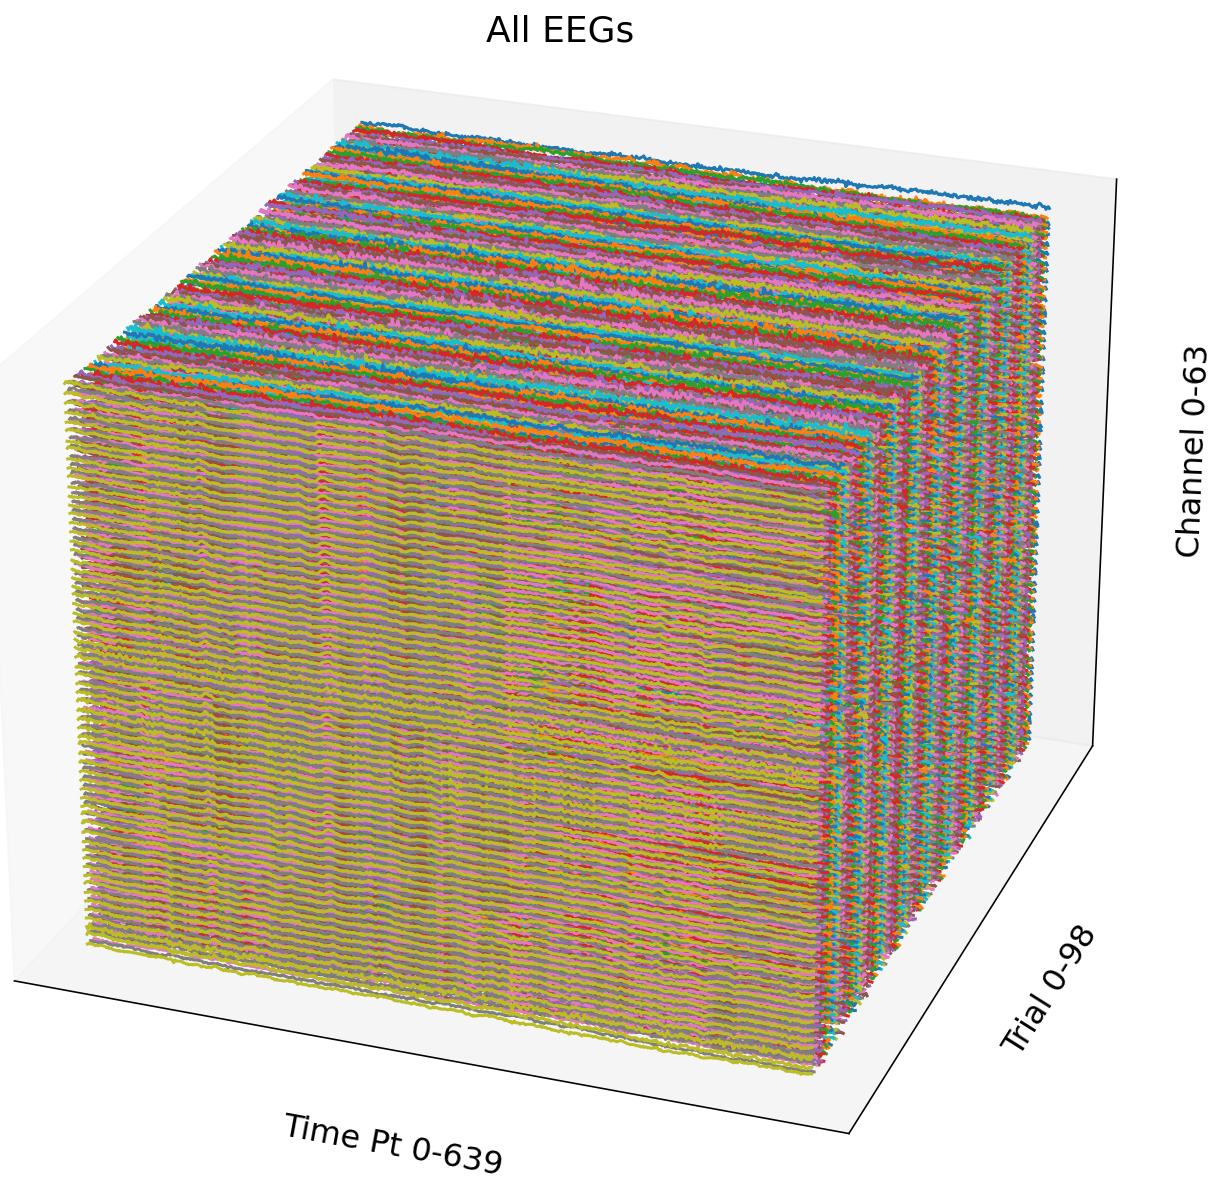

In [4]:
# Visualize all EEGs
fig = plt.figure(figsize=figsize3d)
ax = plt.axes(projection='3d')
for channel in range(64):
    for trial in range(99):
        plt.plot(np.arange(640), np.ones(640) * trial, EEGs[channel,:,trial] - 50*channel, color=cmap[trial%10,:])
ax.set_xlabel('Time Pt 0-639')
ax.set_ylabel('Trial 0-98')
ax.set_zlabel('Channel 0-63')
ax.set_title('All EEGs')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(-155, -110)
ax.dist = dist3d
plt.tight_layout();

Get all EEGs across trials for channel 23.

In [5]:
EEG_23_all = EEGs[23,:,:]

EEG_23_all.shape

(640, 99)

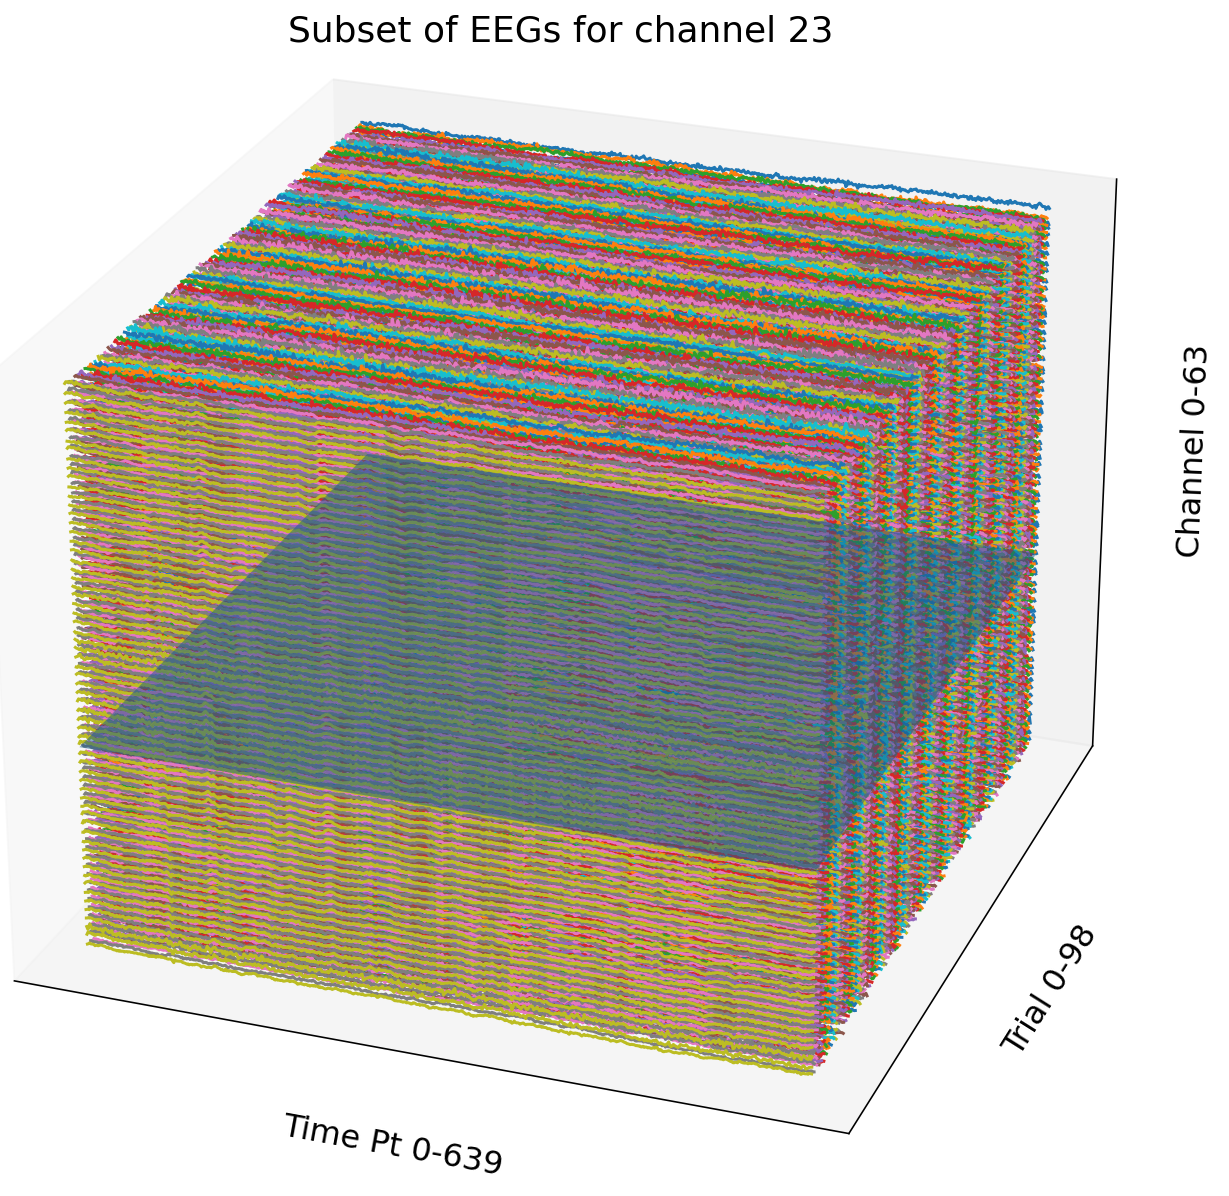

In [6]:
# Visualize subset of EEGs from channel 23
fig = plt.figure(figsize=figsize3d)
ax = plt.axes(projection='3d')
for channel in range(64):
    for trial in range(99):
        plt.plot(np.arange(640), np.ones(640) * trial, EEGs[channel,:,trial] - 50*channel, color=cmap[trial%10,:])
ax.set_xlabel('Time Pt 0-639')
ax.set_ylabel('Trial 0-98')
ax.set_zlabel('Channel 0-63')
ax.set_title('Subset of EEGs for channel 23')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(-155, -110)
ax.dist = dist3d

xx, yy = np.meshgrid(range(640), range(99))
zz = xx.copy()
zz[:] = EEG_23_all.mean() - 50*23
ax.plot_surface(xx, yy, zz, alpha=0.5)

plt.tight_layout();

In [7]:
# average across trials
avgEEGs = EEGs.mean(axis=2)

avgEEGs.shape

(64, 640)

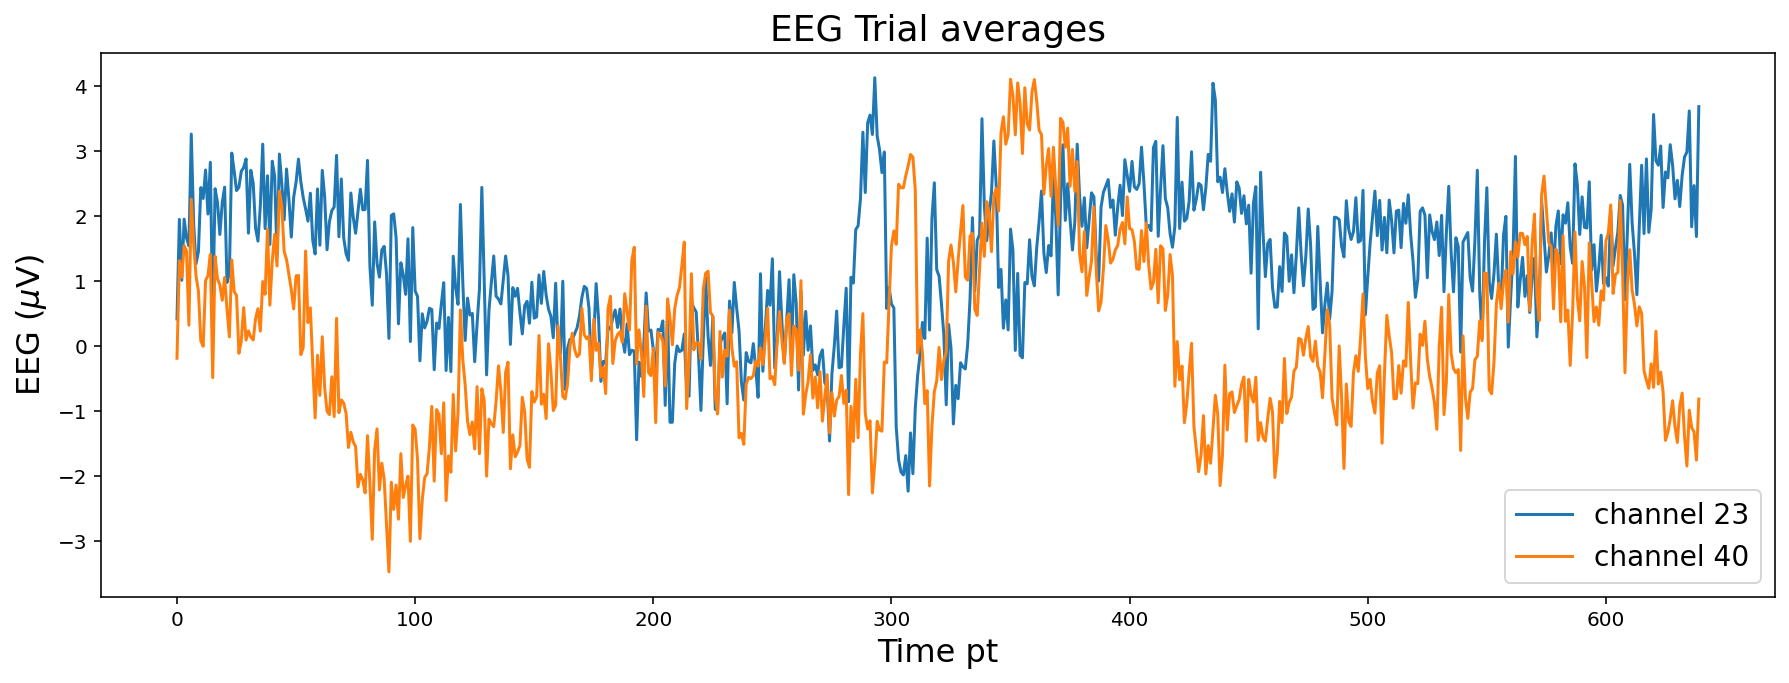

In [8]:
plt.rcParams['figure.figsize'] = [15,5]

plt.plot(avgEEGs[23], label='channel 23')
plt.plot(avgEEGs[40], label='channel 40')
plt.xlabel('Time pt')
plt.ylabel(r'EEG ($\mu$V)')
plt.title('EEG Trial averages')
plt.legend();

Each EEG is 640 time points --> a 640-dimensional vector

We could plot each EEG as a point in a 640-dimensional space

# Question?

Should we standardize the EEG data before performing PCA? Why or why not?

Note: Since each time point is a dimension, this would amount to normalizing the variance across EEGs at each time point.

Can we reasonably explain each 640 sample length EEG with ONLY 3 values instead of 640!?

In [38]:
from sklearn.decomposition import PCA

pca = PCA(3)

# rows are samples (EEGs), columns are features/dimensions (time pts)
pca.fit(avgEEGs)

PCA(n_components=3)

Done! But how do we interpret this?

The three principal component axes are each a direction in the 640-dimensional coordinate system for the EEGs.

In [39]:
pca.components_.shape

(3, 640)

The 640-dimensional coordinate system for the EEGs represents the observed EEG amplitude ($\mu V$) at each of the 640 time points.

The direction of each principal component defines a particular set of relative amplitudes at all 640 time points.

In [40]:
# this function will draw an arrow from point v0 to point v1
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->', linewidth=2, color='black', shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

In [69]:
pca.components_[1,:2], pca.mean_[:2]

(array([-0.03941354, -0.07643614], dtype=float32),
 array([0.57335925, 2.465269  ], dtype=float32))

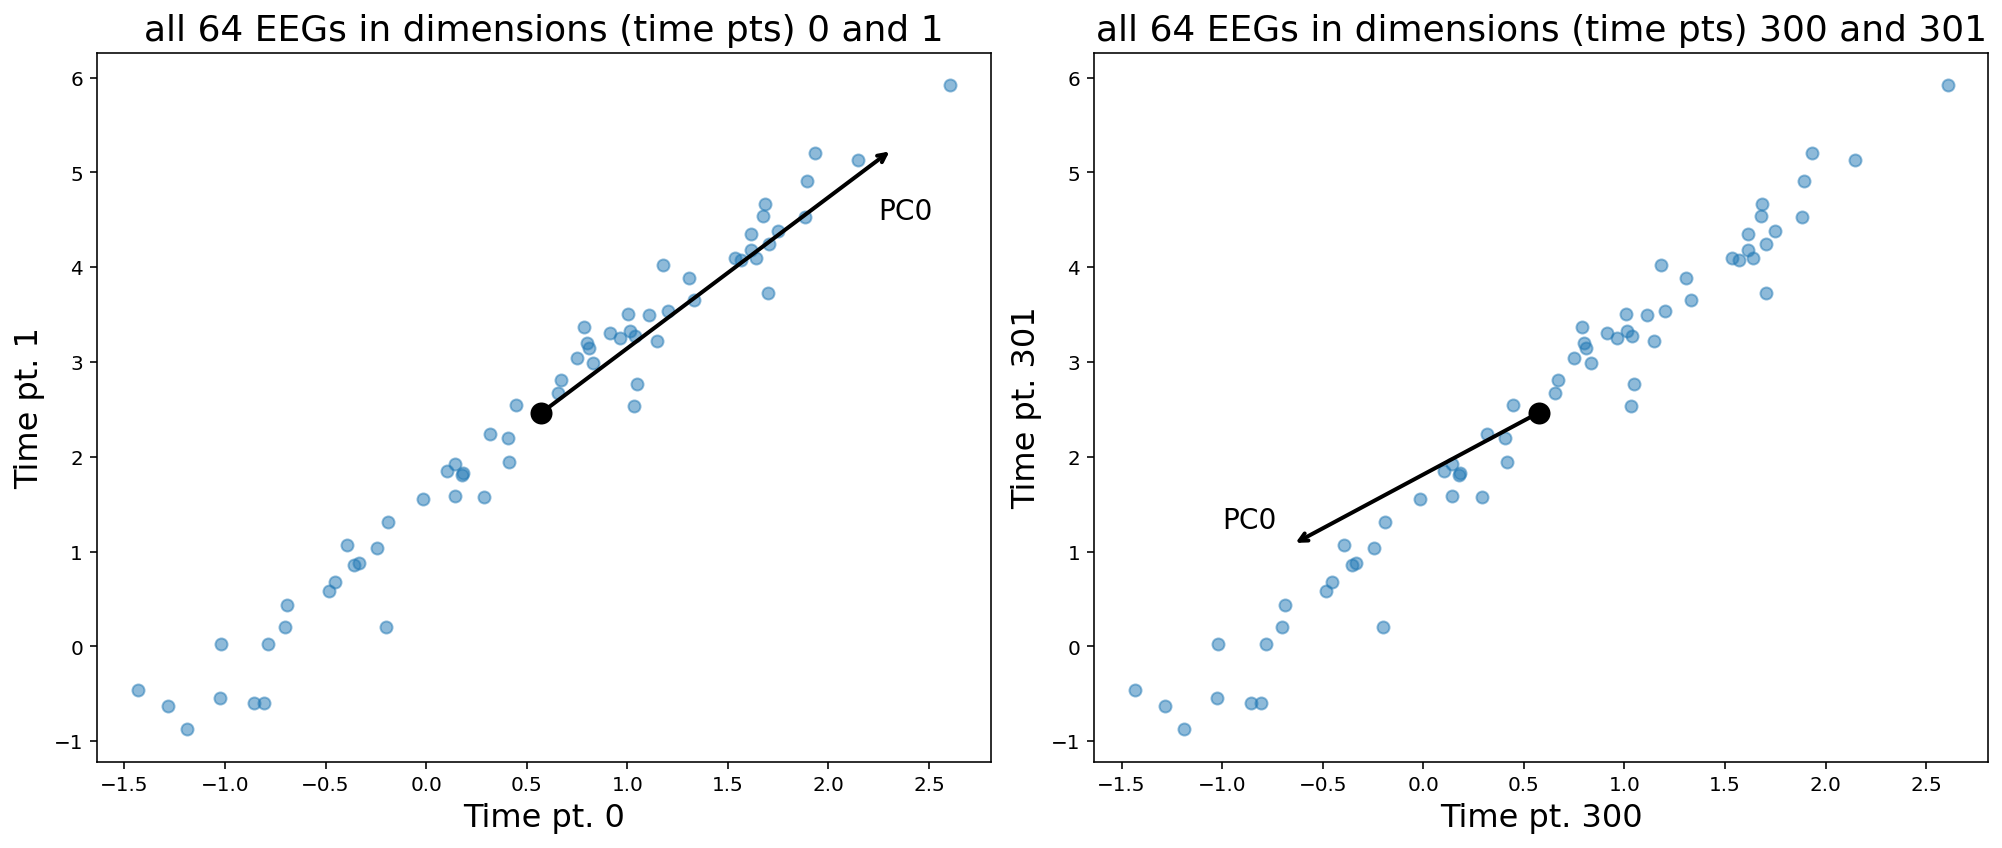

In [89]:
# PCs projected onto two time points
plt.figure(figsize=[14,6])
for i, t in enumerate([0, 300]):
    plt.subplot(1, 2, i+1)
    plt.plot(avgEEGs[:,0], avgEEGs[:,1], 'o', alpha=0.5)
    plt.plot(pca.mean_[0], pca.mean_[1], 'ko', mfc='k', ms=10);
    draw_vector(pca.mean_[:2], pca.mean_[:2] + pca.components_[0,t:t+2] * 75)
    plt.xlabel(f'Time pt. {t}')
    plt.ylabel(f'Time pt. {t+1}')
    plt.title(f'all 64 EEGs in dimensions (time pts) {t} and {t+1}')
plt.subplot(121)
plt.text(2.25, 4.5, 'PC0', fontsize=14)
plt.subplot(122)
plt.text(-1, 1.25, 'PC0', fontsize=14)
plt.tight_layout();

Thus, each principal component defines a particular EEG waveform shape.

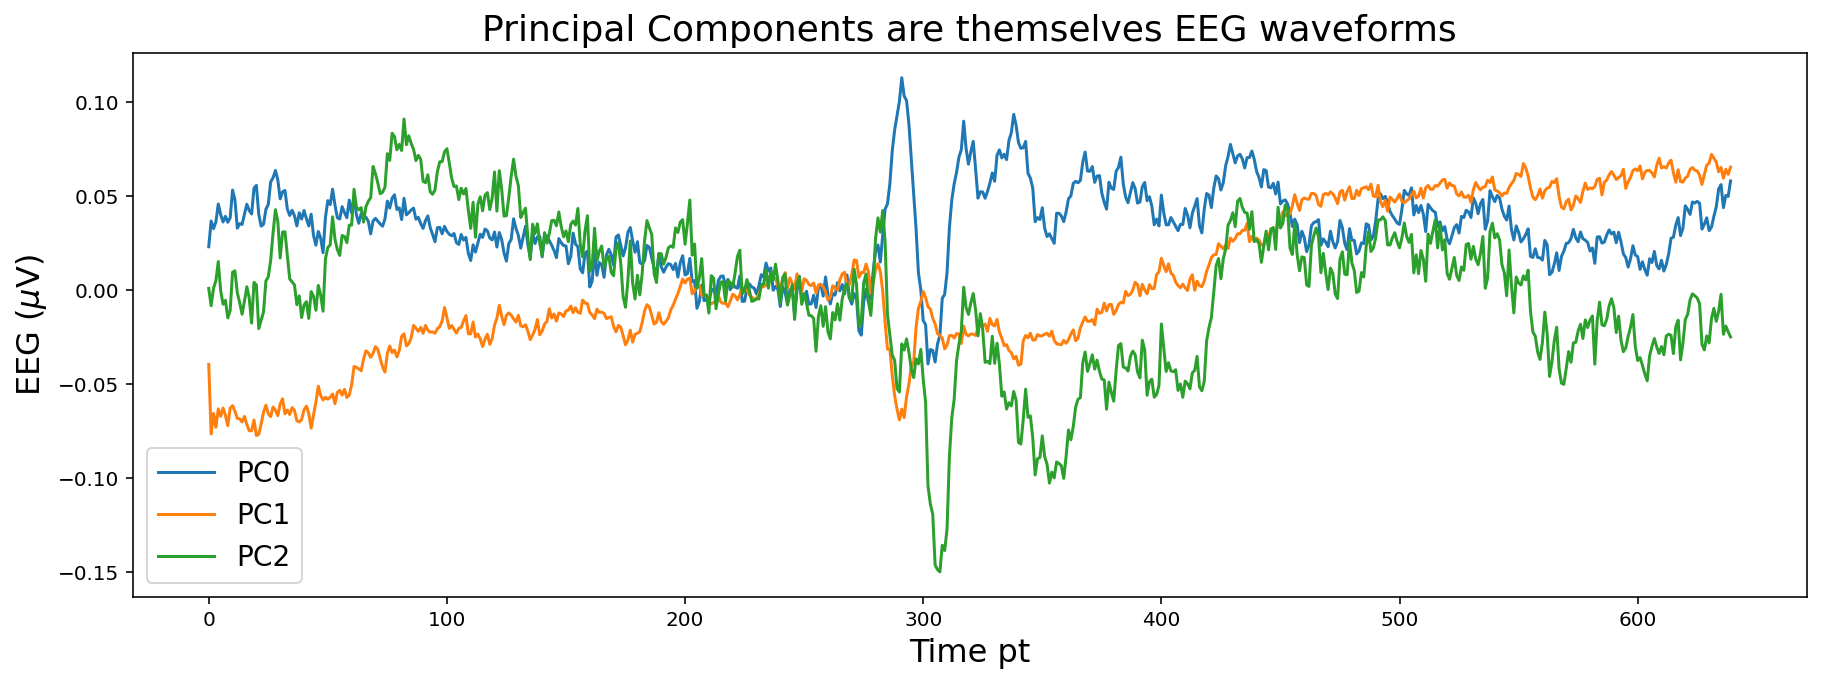

In [11]:
for i in range(3):
    plt.plot(pca.components_[i,:], label=f'PC{i}')
plt.xlabel('Time pt')
plt.ylabel('EEG ($\mu$V)')
plt.title('Principal Components are themselves EEG waveforms')
plt.legend();

So when we describe each 640 sample length EEG with only 3 values, what we are actually doing is describing each EEG as a mixture of the 3 principal component EEG shapes.

In [12]:
avgEEGs_pca = pca.transform(avgEEGs)

avgEEGs_pca.shape

(64, 3)

In [13]:
avgEEGs_pca[:5,:]

array([[-50.39     ,   5.429818 ,   9.518048 ],
       [-44.33464  ,  12.796197 ,   6.094209 ],
       [-39.274586 ,  -9.802853 ,   2.4354672],
       [ -8.723732 ,  32.09606  , -19.6233   ],
       [-27.016556 ,   8.502502 ,  -5.048856 ]], dtype=float32)

Let's see how well a mixture of the 3 principal components can describe the average EEG in channel 0.

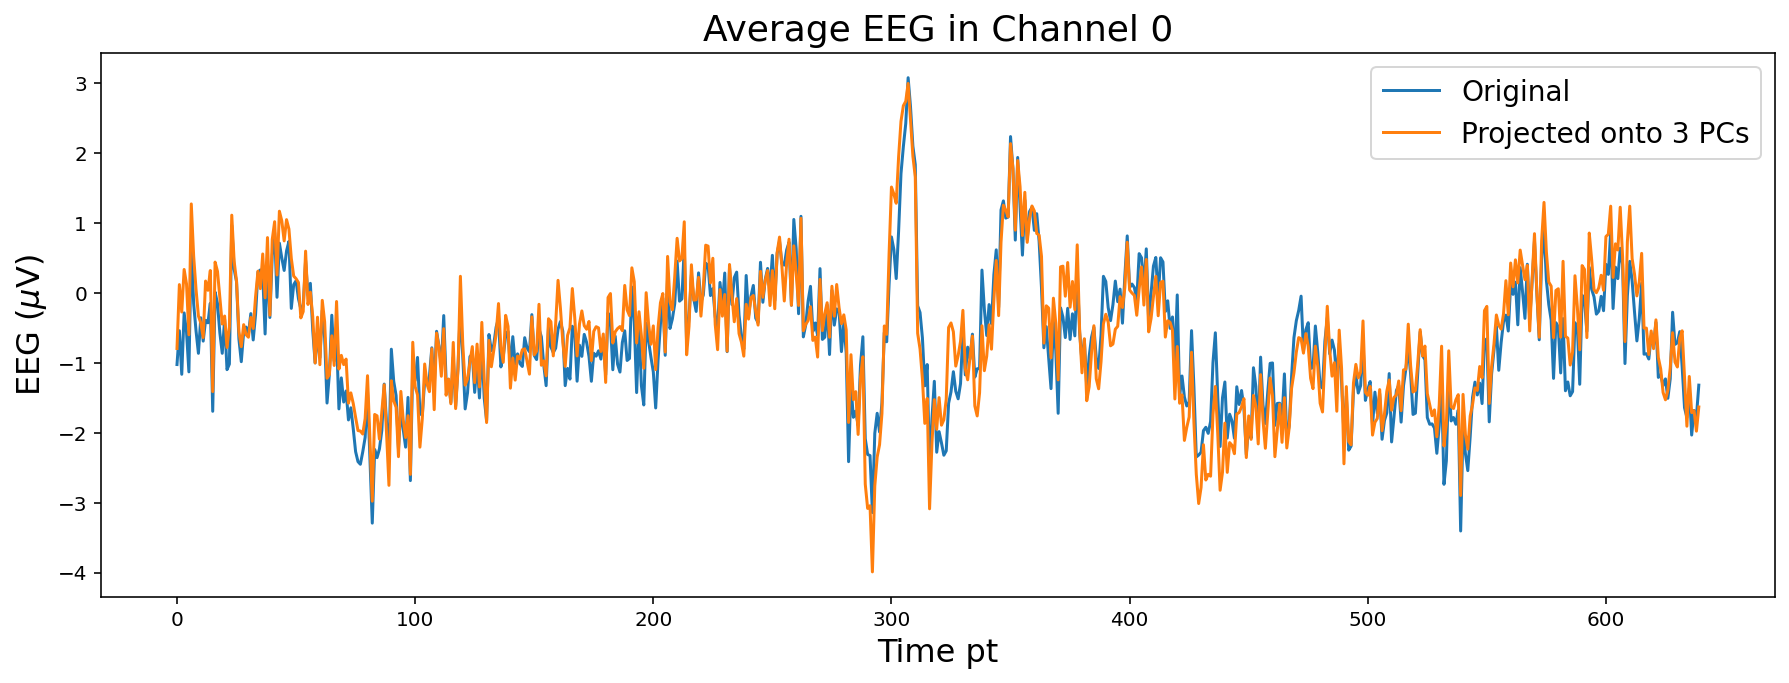

In [14]:
avgEEG0 = avgEEGs[0,:]

# PCA components are relative to the mean across the EEG dataset
avgEEG0_pca = pca.mean_.copy()  # !!! <-- If we don't copy this we'll end up changing pca.mean_
for i in range(3):
    avgEEG0_pca += (avgEEGs_pca[0,i] * pca.components_[i,:])

plt.plot(avgEEG0, label="Original")
plt.plot(avgEEG0_pca, label="Projected onto 3 PCs")
plt.xlabel('Time pt')
plt.ylabel('EEG ($\mu$V)')
plt.title('Average EEG in Channel 0');
plt.legend();

`pca.inverse_transform(avgEEGs_pca)` does this mixing for us for the entire dataset...

In [15]:
avgEEGs_projected = pca.inverse_transform(avgEEGs_pca)

avgEEGs_projected.shape

(64, 640)

Let's see how good it did for channel 9...

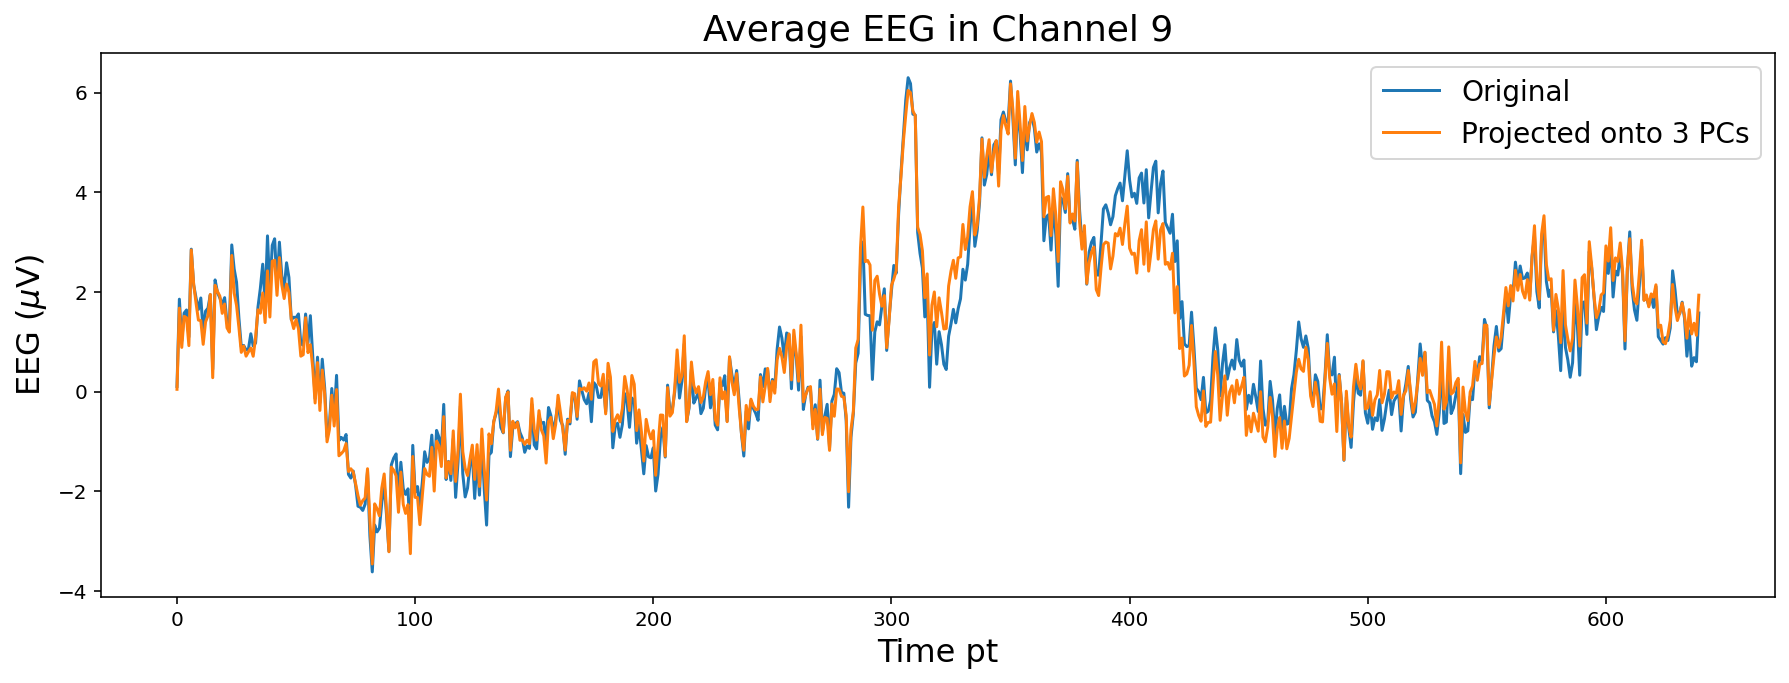

In [16]:
plt.plot(avgEEGs[9,:], label="Original")
plt.plot(avgEEGs_projected[9,:], label="Projected onto 3 PCs")
plt.xlabel('Time pt')
plt.ylabel('EEG ($\mu$V)')
plt.title('Average EEG in Channel 9');
plt.legend();

The PCA projected EEGs look like they are a pretty good representation of the original EEGs, but there are some differences due to the fact that we threw out the variance along 637 dimensions!

How much information did we lose? Or conversely, how much of the variance in the data do we still explain after projecting each EEG onto only 3 dimensions?

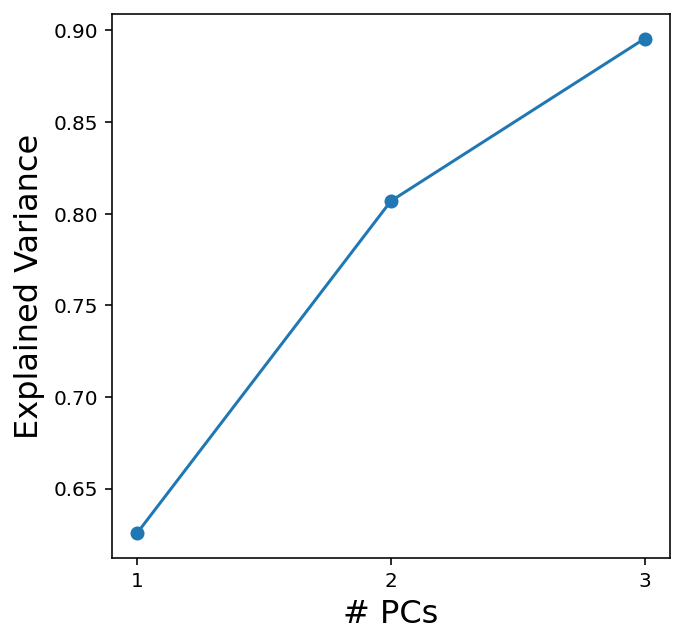

In [17]:
plt.figure(figsize=[5,5])
numPC = np.arange(1, 4)
plt.plot(numPC, np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xticks(numPC)
plt.xlabel('# PCs')
plt.ylabel('Explained Variance');

Wow, ~90% of variance explained using ONLY 3 PCs!

Let's plot all of our 64 EEG waveforms in the projected 3-dimensional PCA space.

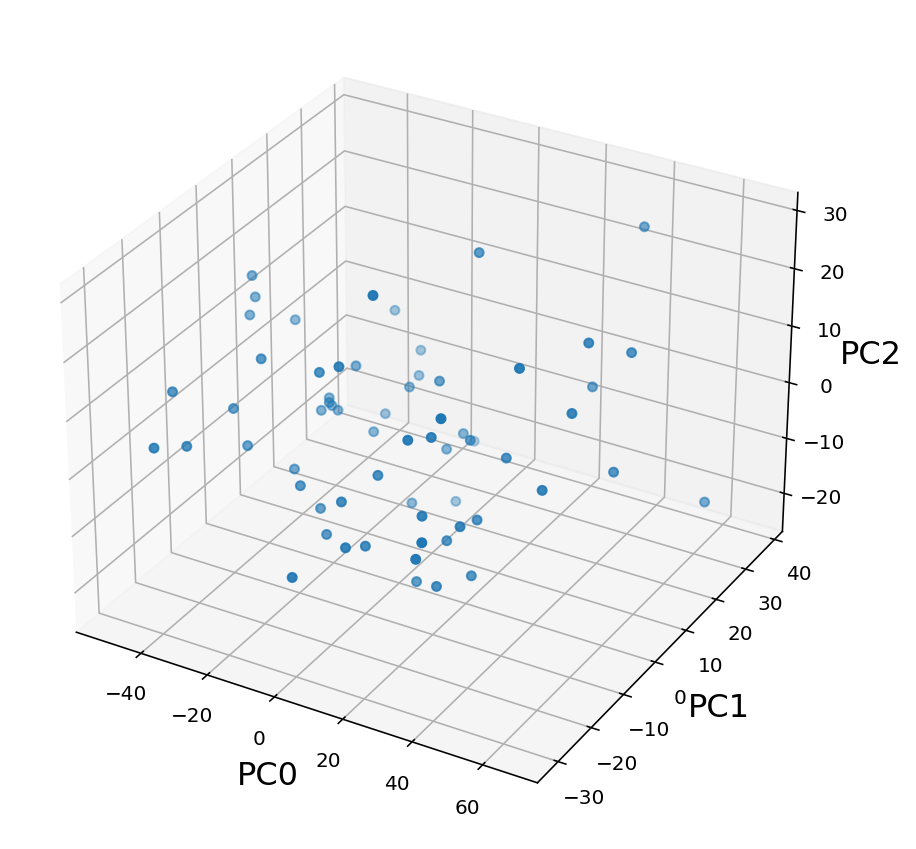

In [21]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(avgEEGs_pca[:,0], avgEEGs_pca[:,1], avgEEGs_pca[:,2])
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
fig.tight_layout();

Let's try clustering these recordings into two groups using $k$-means...

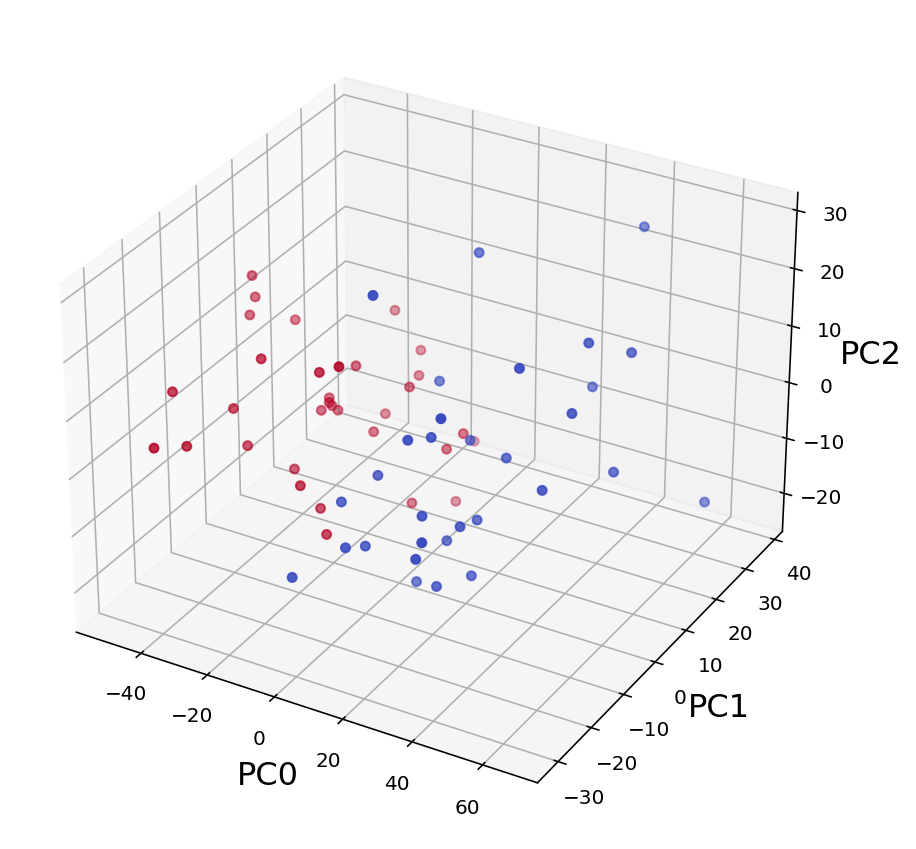

In [22]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(avgEEGs_pca)

fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(avgEEGs_pca[:,0], avgEEGs_pca[:,1], avgEEGs_pca[:,2], c=labels, cmap='coolwarm')
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
fig.tight_layout();

Do waveforms in each cluster have distinct shapes?

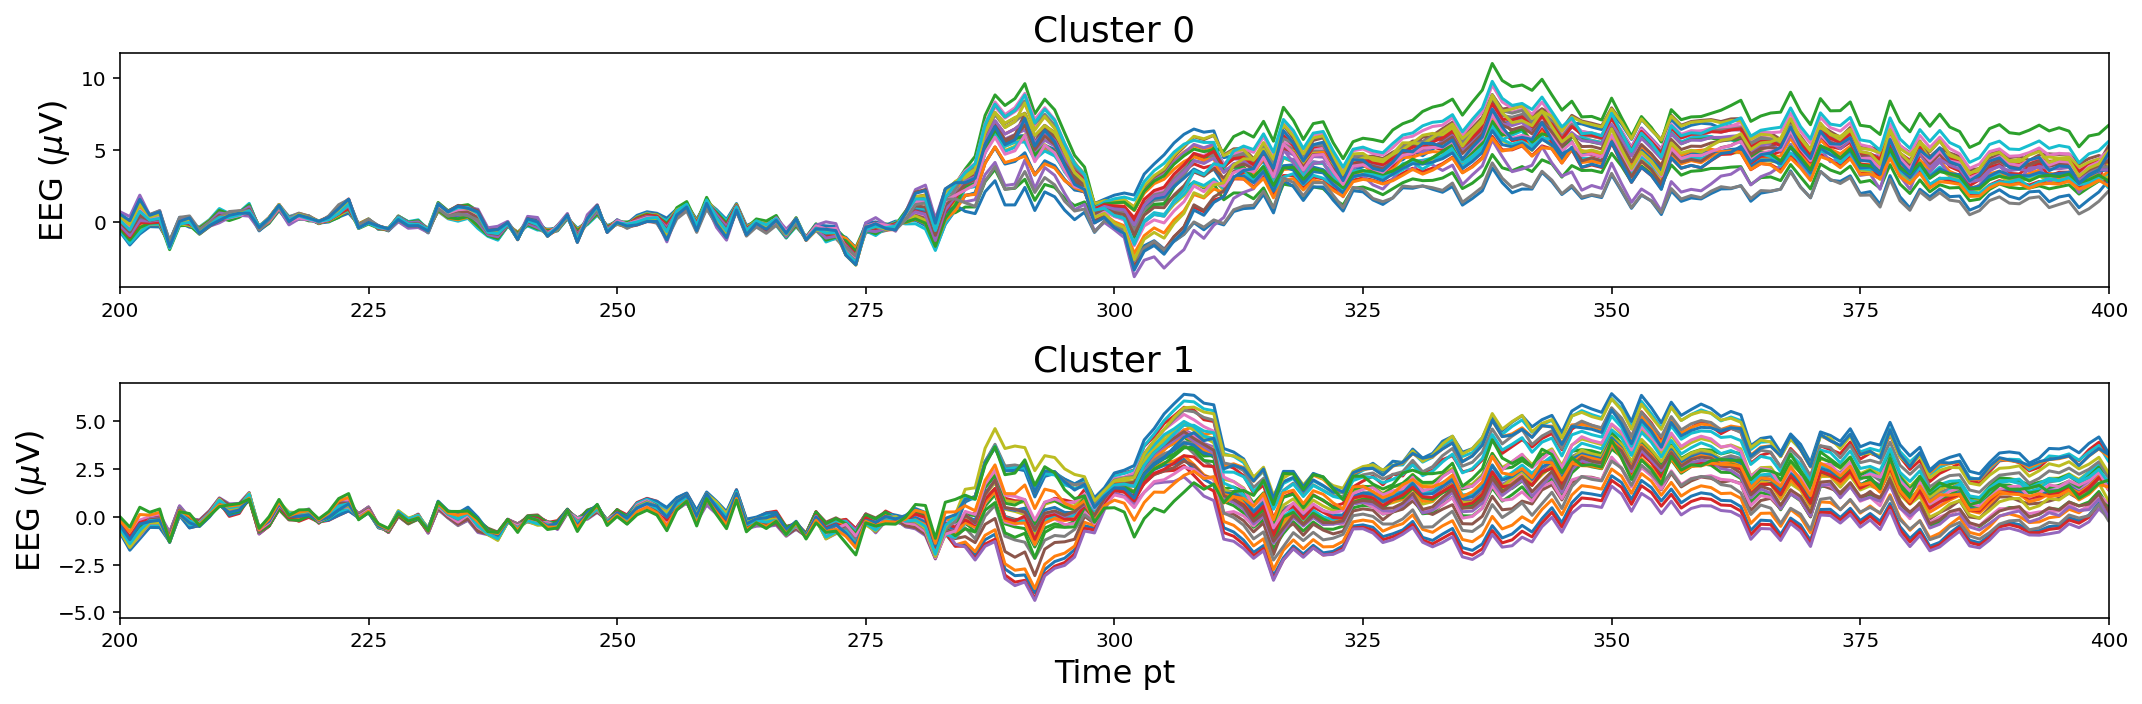

In [26]:
[fig, ax] = plt.subplots(2, 1)
for channel in range(64):
    cluster = labels[channel]
    ax[cluster].plot(avgEEGs_projected[channel,:])
ax[0].set_ylabel('EEG ($\mu$V)')
ax[0].set_title('Cluster 0')
ax[1].set_xlabel('Time pt')
ax[1].set_ylabel('EEG ($\mu$V)')
ax[1].set_title('Cluster 1')
ax[0].set_xlim([200, 400])
ax[1].set_xlim([200, 400])
plt.tight_layout();

Let's try clustering with a GMM and using BIC or AIC or silhouette score to determine the optimal number of clusters...

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

X = avgEEGs_pca

n_components = np.arange(1, 9)
models = [GaussianMixture(n_components=n, random_state=0) for n in n_components]
for model in models:
    model.fit(X)
    
bic = [model.bic(X) for model in models]
aic = [model.aic(X) for model in models]
silhouette = [silhouette_score(X, model.predict(X)) for model in models[1:]]

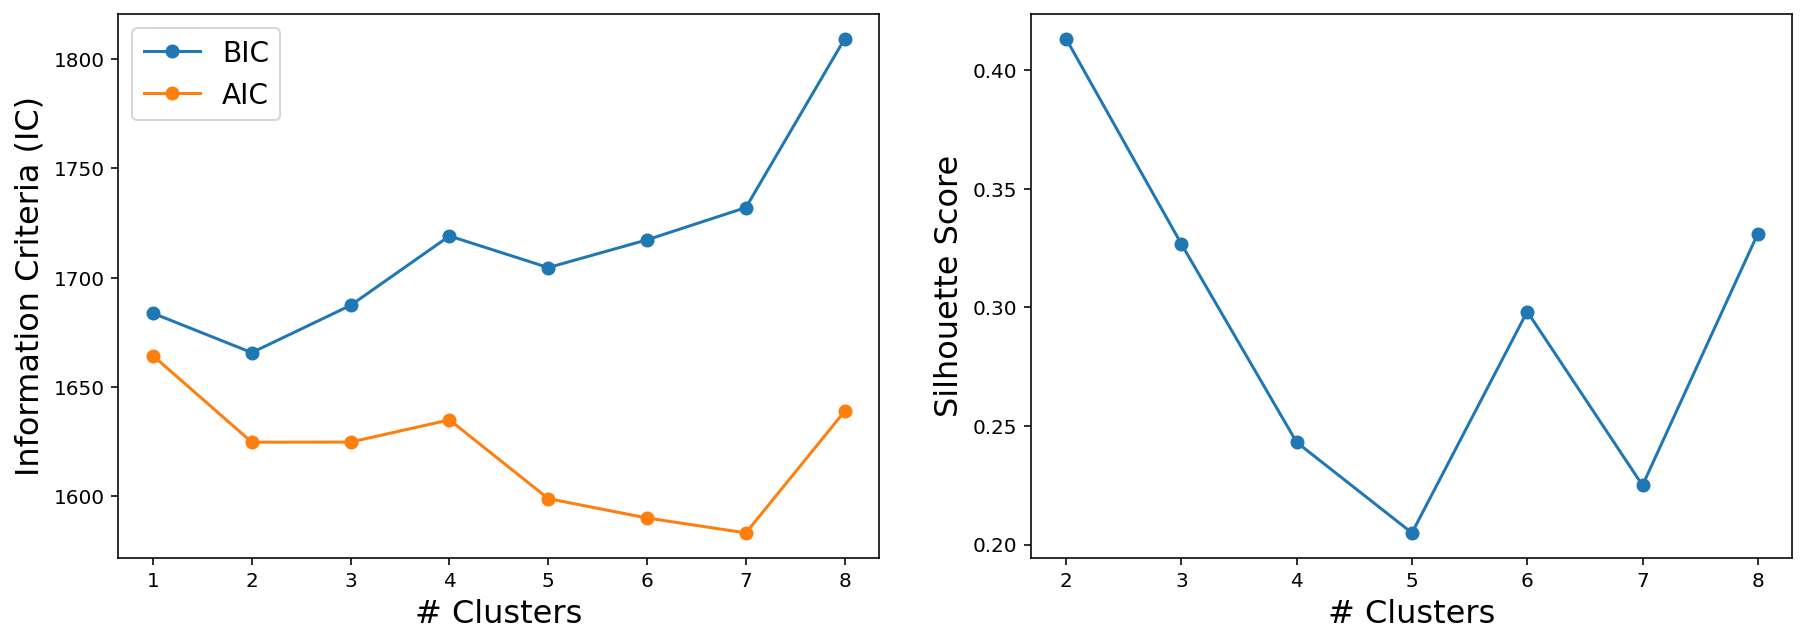

In [31]:
plt.subplot(121)
plt.plot(n_components, bic, 'o-', label='BIC')
plt.plot(n_components, aic, 'o-', label='AIC')
plt.xlabel('# Clusters');
plt.ylabel('Information Criteria (IC)')
plt.legend()
plt.subplot(122)
plt.plot(n_components[1:], silhouette, 'o-', label='Silhouette Score')
plt.xlabel('# Clusters');
plt.ylabel('Silhouette Score');

Cluster EEGs using a GMM with 2 components.

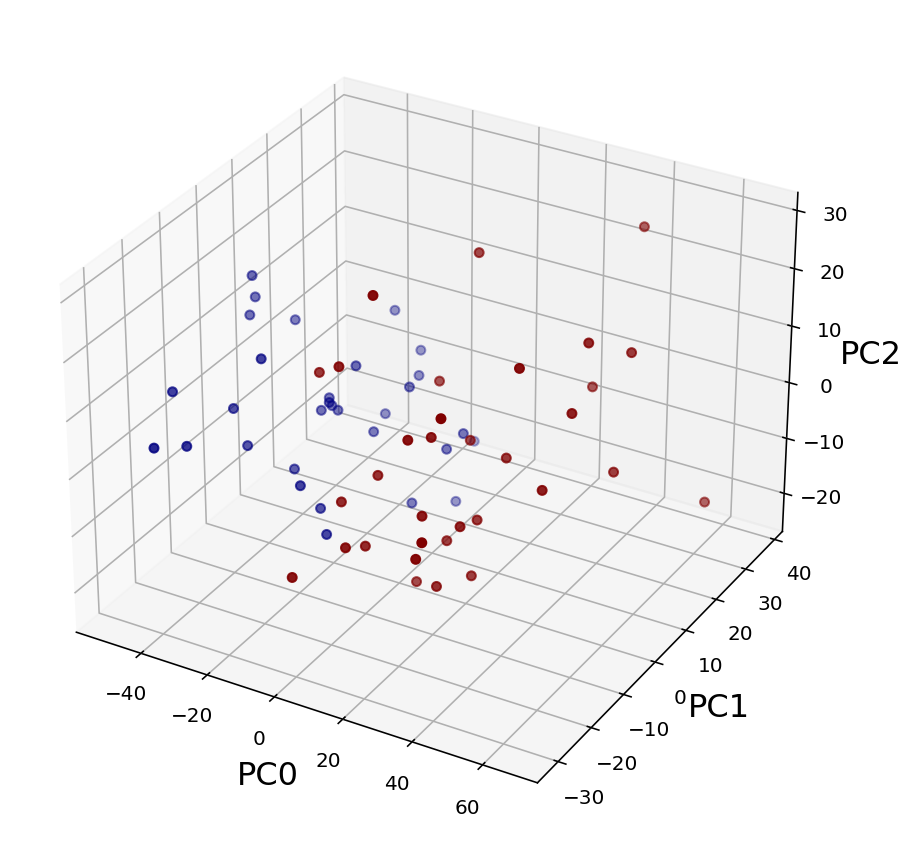

In [32]:
gmm = GaussianMixture(n_components=2)
labels = gmm.fit_predict(avgEEGs_pca)

fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(avgEEGs_pca[:,0], avgEEGs_pca[:,1], avgEEGs_pca[:,2], c=labels, cmap='jet')
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
fig.tight_layout();

Visualize waveforms in each cluster.

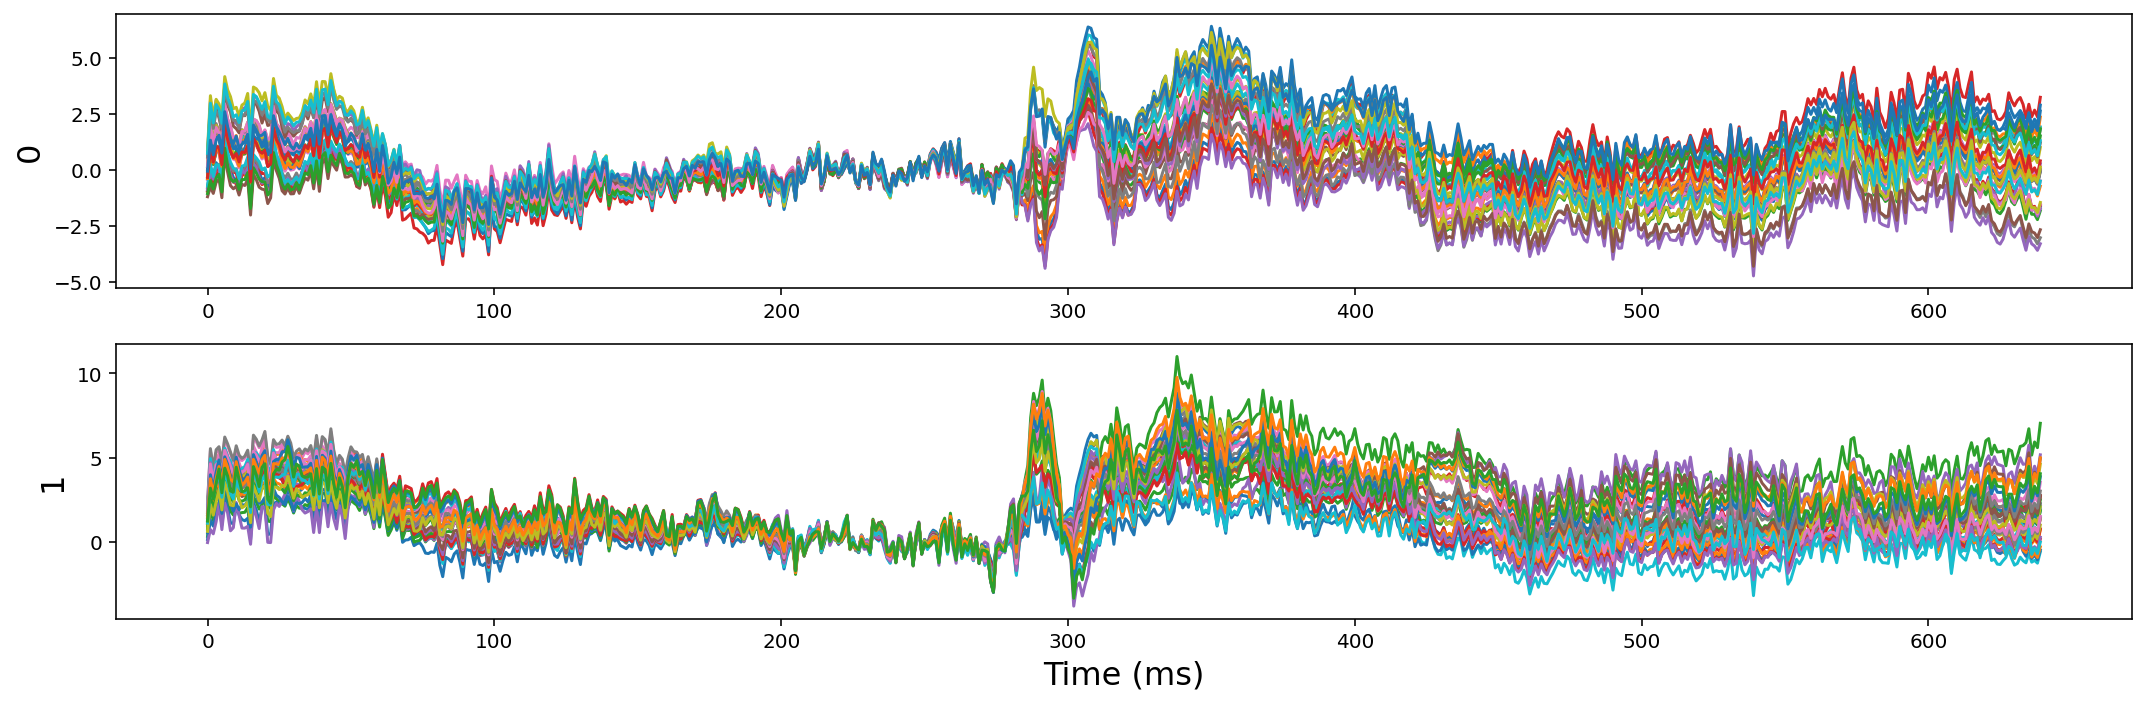

In [33]:
[fig, ax] = plt.subplots(n, 1)
for channel in range(64):
    cluster = labels[channel]
    ax[cluster].plot(avgEEGs_projected[channel,:])
for i in range(n):
    ax[i].set_ylabel(i)
ax[-1].set_xlabel('Time (ms)')
plt.tight_layout();

# Exercise

Try clustering again with 3 or 7 components using a GMM.

Plot the clusters on the first three principal component axes.